In [0]:
import torch 
import torch.nn as nn
from matplotlib import pyplot as plt

In [0]:
eps = 1e-2
rho = 1
l = 0.1
c_ = 2
T_eps = int(l/(rho*eps)**0.5+1)*10
L = 5

In [0]:
X = torch.randn(1000,10,1)
c_true = torch.rand(1, 10)
Y = c_true @ X + torch.randn(1000, 1, 1) * 0.1

In [55]:
c_true

tensor([[0.4828, 0.1032, 0.7481, 0.5261, 0.4966, 0.0204, 0.5854, 0.1696, 0.2488,
         0.0127]])

In [0]:
def rosenbrock(x, y, w):
    value = (1 - w - x - y) ** 2 + 100 * (1 - (w + x + y) ** 2) ** 2
    return value.mean()

In [0]:
def f(x, y, w):
    return torch.norm(w @ x - y).pow(4).mean()
    t = w[0][0]
    eps_sqrt = eps**0.5
    if t <= -L*eps_sqrt:
      return eps_sqrt*(t+(L+1)*eps_sqrt)**2 - 1/3*(t + (L+1)*eps_sqrt)**3 - 1/3*(3*L+1)*eps**(3/2)
    if -L*eps_sqrt < t <= -eps_sqrt:
      return eps*t+eps*(3/2)/3
    if -eps_sqrt < t <=0:
      return -eps_sqrt*t**2 - t**3/3
    if 0 < t <= eps_sqrt:
      return -eps_sqrt*t**2 + t**3/3
    if eps_sqrt < t <= L*eps_sqrt:
      return -eps*t+eps**(3/2)/3
    if L*eps_sqrt <= t:
      return eps_sqrt*(t - (L+1)*eps_sqrt)**2 + 1/3*(t - (L+1)*eps_sqrt)**3 - 1/3*(3*L+1)*eps**(3/2)

In [0]:
def batch(X, Y, batch_size=2):
    indices = torch.randperm(X.size(0))[:batch_size]
    return X[indices], Y[indices]

In [0]:
def cubic_regularization(eps=None):
    w = torch.randn(1, 10, requires_grad=True)
    c = -(eps ** 3 / rho) ** (0.5) / 100
    w_norm_history = []
    for i in range(100):
        if i % 10 == 0: print(w)
        x, y = batch(X, Y)
        f(x, y, w).backward()
        grad = w.grad.clone()/100
        hessian = torch.autograd.functional.hessian(f, inputs=(x, y, w))[2][2].squeeze().squeeze()/100
        delta, delta_m = cubic_subsolver(grad, hessian, eps)
        w_new = w.detach() + delta
        if delta_m.item() >= c:
            delta = cubic_finalsolver(grad, hessian, eps)
            return w + delta, w_norm_history
        w = w_new
        w.requires_grad = True
        w_norm_history.append(torch.norm(w - c_true).item())
    return w, w_norm_history

In [0]:
def cubic_subsolver(grad, hessian, eps):
    g_norm = torch.norm(grad)
    # print(g_norm)
    if g_norm > l**2 / rho:
        temp = grad @ hessian @ grad.T / rho / g_norm.pow(2) 
        R_c = -temp + torch.sqrt(temp.pow(2) + 2 * g_norm / rho)
        delta = -R_c * grad / g_norm
    else:
        delta = torch.zeros(grad.size())
        sigma = c_ * (eps * rho)**0.5 / l
        mu = 1.0 / (20.0 * l)
        vec = -torch.rand(grad.size())*2 + torch.ones(grad.size())
        vec /= torch.norm(vec)
        g_ = grad + sigma * vec
        # g_ = grad
        for _ in range(T_eps):
            delta -= mu *(g_ + delta @ hessian + rho / 2 * torch.norm(delta) * delta)
        
    delta_m = grad @ delta.T + delta @ hessian @ delta.T / 2 + rho / 6 * torch.norm(delta).pow(3)
    return delta, delta_m

In [0]:
def cubic_finalsolver(grad, hessian, eps):
    delta = torch.zeros(grad.size())
    g_m = grad
    print(torch.norm(g_m))
    mu = 1 / (20 * l)
    while torch.norm(g_m) > eps/2:
        delta -= mu * g_m
        g_m = grad + delta @ hessian + rho / 2 * torch.norm(delta) * delta
    return delta

In [107]:
c_true

tensor([[0.4828, 0.1032, 0.7481, 0.5261, 0.4966, 0.0204, 0.5854, 0.1696, 0.2488,
         0.0127]])

In [108]:
w0, hist = cubic_regularization(eps)
print(w0)

tensor([[-0.1905, -0.6181,  0.0187, -0.2390, -1.2034, -0.2535,  0.4507, -0.8767,
          0.6222,  0.6722]], requires_grad=True)
tensor([[ 0.1707, -0.1809,  0.2822,  0.3808, -0.4329, -0.1584,  0.3988, -0.7068,
          0.5366,  0.0734]], requires_grad=True)
tensor([[ 0.2665, -0.1712,  0.3891,  0.4338, -0.0084, -0.1159,  0.5071, -0.1882,
          0.6515,  0.1726]], requires_grad=True)
tensor(0.0020)
tensor([[ 4.1827e-01, -8.6350e-02,  5.5787e-01,  4.8142e-01,  1.1322e-01,
          2.0705e-04,  4.6000e-01,  3.5408e-03,  5.2995e-01,  1.7385e-01]],
       grad_fn=<AddBackward0>)


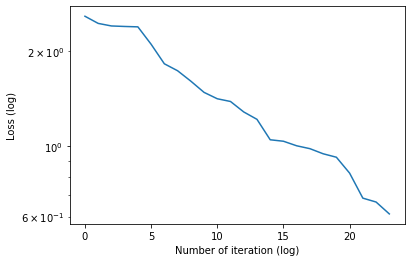

In [109]:
plt.plot(range(len(hist)), hist)
plt.xlabel('Number of iteration (log)')
plt.ylabel('Loss (log)')
# plt.xscale('log')
plt.yscale('log')
plt.show()

In [110]:
|

SyntaxError: ignored